In [1]:
!pip install requests transformers accelerate bitsandbytes matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.1/362.1 KB 4.4 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 9.0 MB/s eta 0:00:000m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 12.3 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 13.1 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.6 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 13.0 MB/s eta 0:00:00


## Setup
Methods for retreiving GitHub issues and then filtering and aggregating them.

In [2]:
TOPIC_KEYWORDS_PYTHON = {
    "dataset": ["dataset", "Dataset", "open_dataset", "write_dataset"],
    "compute": ["compute", "expression", "filter", "join", "hash"],
    "ipc": ["ipc", "streaming format", "file format"],
    "feather": ["feather", "read_feather", "write_feather"],
    "tables": ["Table", "RecordBatch", "Schema"],
    "filesystem": ["LocalFileSystem", "azure", "fs", "filesystem", "S3", "HDFS"],
    "pandas": ["pandas", "to_pandas", "from_pandas"],
    "parquet": ["parquet", "ParquetFile", "ParquetDataset"],
    "acero": ["acero", "Declaration"],
    "extension": ["extension types", "ExtensionType", "ExtensionArray"],
    "install": ["pip install", "build", "wheel", "conda", "mamba"]
}

In [3]:
import requests

def fetch_issues_by_year(repo, year, state='open', per_page=100):
    issues = []
    url = "https://api.github.com/search/issues"
    headers = {"Accept": "application/vnd.github+json"}
    # Search query for issues created in given year and state
    query = f"repo:{repo} is:issue is:{state} created:{year}-01-01..{year}-12-31"
    params = {"q": query, "per_page": per_page, "page": 1}

    while True:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()
        data = response.json()
        issues.extend(data.get("items", []))
        # Pagination logic: stop if no more pages
        if 'next' not in response.links:
            break
        params['page'] += 1
    return issues

# Example: fetch open issues created in 2025
issues_2025 = fetch_issues_by_year("apache/arrow", 2025)
print(f"Found {len(issues_2025)} open issues created in 2024/2025.")

Found 360 open issues created in 2024/2025.


Filter issues by the keywords included in the issue title and body

In [4]:
def filter_issues_by_keywords(issues, keywords_dict):
    filtered_issues = {key: [] for key in keywords_dict}
    for issue in issues:
      for label in issue["labels"]:
        if label["name"] == "Component: Python":
          for topic, keywords in keywords_dict.items():
              if any(keyword.lower() in (issue['title'] + ' ' + (issue.get('body', '') or '')).lower() for keyword in keywords):
                  filtered_issues[topic].append(issue)
    return filtered_issues

filtered_issues = filter_issues_by_keywords(issues_2025, TOPIC_KEYWORDS_PYTHON)

Aggregate issues that are classified by the model

In [5]:
from collections import defaultdict, Counter

def aggregate_pain_points(issues):
    keyword_counts = {key: len(issue_list) for key, issue_list in issues.items()}
    pain_point_counts = Counter()
    pain_point_by_topic = defaultdict(Counter)

    for topic, issue_list in issues.items():
        for issue in issue_list:
            pain_points = issue.get('pain_point', '')
            for point in [p.strip() for p in pain_points.split(',') if p.strip()]:
                pain_point_counts[point] += 1
                pain_point_by_topic[topic][point] += 1

    return keyword_counts, pain_point_counts, pain_point_by_topic

## Classification model

In [6]:
from transformers import pipeline

generator = pipeline(
    "text2text-generation",
    model="google/flan-t5-base",
    device=-1,
)

def classify_pain_point_flan(issue_title, issue_body):

    issue_title = issue_title[:100]
    issue_body = issue_body[:500]

    prompt = f"""
You are an expert in PyArrow. Classify the following GitHub issue into one or more of these categories:
Bugs, Documentation and usage questions, Feature, Interoperability, Performance.

Return only the category or categories, separated by commas.

Title: {issue_title}
Body: {issue_body}
"""
    result = generator(prompt, max_new_tokens=50)
    return result[0]["generated_text"].strip().split('\n')[0]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [7]:
def classify_issues_flan(issues):
    for topic, issue_list in issues.items():
        for issue in issue_list:
            issue_title = issue.get('title') or ""
            issue_body = issue.get('body') or ""
            if issue_body == "":
                continue
            issue['pain_point'] = classify_pain_point_flan(issue_title, issue_body)
    return issues

# Assuming filtered_issues is your dict of issues by topic
classified_issues = classify_issues_flan(filtered_issues)

In [8]:
keyword_counts, pain_point_counts, pain_point_by_topic = aggregate_pain_points(classified_issues)

print("Keyword Counts:", keyword_counts)
print("Pain Point Counts:", pain_point_counts)
print("Pain Point Counts by topics:", pain_point_by_topic)

Keyword Counts: {'dataset': 32, 'compute': 31, 'ipc': 3, 'feather': 3, 'tables': 55, 'filesystem': 19, 'pandas': 26, 'parquet': 37, 'acero': 5, 'extension': 3, 'install': 18}
Pain Point Counts: Counter({'Bugs': 195, 'Feature': 21, 'Documentation and usage questions': 11, 'Feature ------': 5})
Pain Point Counts by topics: defaultdict(<class 'collections.Counter'>, {'dataset': Counter({'Bugs': 27, 'Documentation and usage questions': 2, 'Feature': 2, 'Feature ------': 1}), 'compute': Counter({'Bugs': 22, 'Feature': 6, 'Documentation and usage questions': 2, 'Feature ------': 1}), 'ipc': Counter({'Bugs': 2, 'Documentation and usage questions': 1}), 'feather': Counter({'Bugs': 3}), 'tables': Counter({'Bugs': 49, 'Feature': 3, 'Documentation and usage questions': 2, 'Feature ------': 1}), 'filesystem': Counter({'Bugs': 16, 'Feature': 2, 'Feature ------': 1}), 'pandas': Counter({'Bugs': 24, 'Documentation and usage questions': 1, 'Feature': 1}), 'parquet': Counter({'Bugs': 31, 'Feature': 4, 

# Plotting

In [9]:
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [10]:
import matplotlib.pyplot as plt

In [11]:
keyword_counts.keys(), keyword_counts.values()

(dict_keys(['dataset', 'compute', 'ipc', 'feather', 'tables', 'filesystem', 'pandas', 'parquet', 'acero', 'extension', 'install']),
 dict_values([32, 31, 3, 3, 55, 19, 26, 37, 5, 3, 18]))

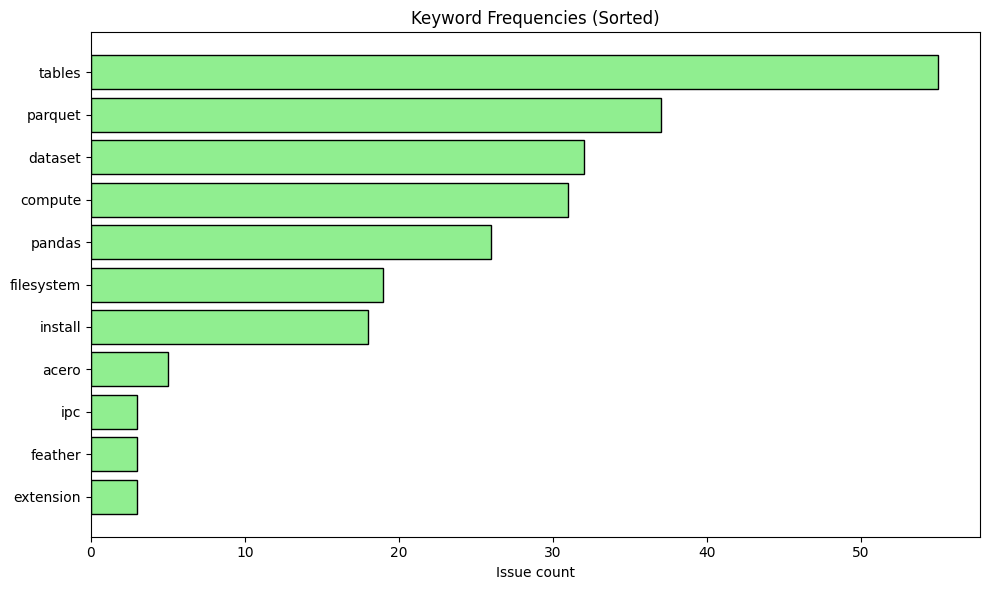

In [12]:
component = keyword_counts.keys()
values_1 = keyword_counts.values()

keywords, counts = zip(*sorted(zip(component, values_1), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(10, 6))
plt.barh(keywords, counts, color='lightgreen', edgecolor='black')
plt.xlabel('Issue count')
plt.title('Keyword Frequencies (Sorted)')
plt.gca().invert_yaxis()  # Most frequent at the top
plt.tight_layout()

plt.show()

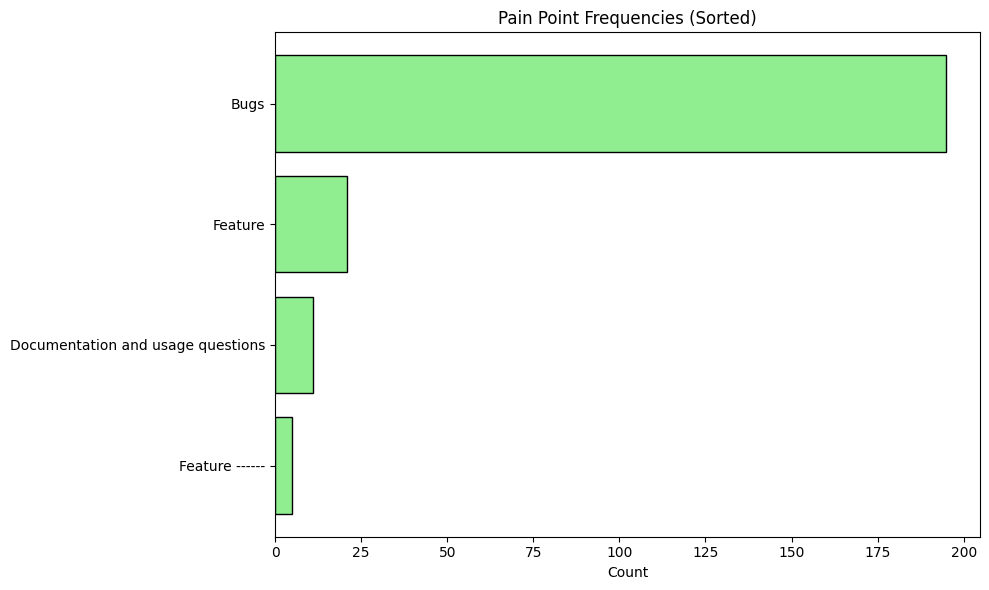

In [13]:
pain_point_counts.keys(), pain_point_counts.values()

pains = pain_point_counts.keys()
values_2 = pain_point_counts.values()

keywords, counts = zip(*sorted(zip(pains, values_2), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(10, 6))
plt.barh(keywords, counts, color='lightgreen', edgecolor='black')
plt.xlabel('Count')
plt.title('Pain Point Frequencies (Sorted)')
plt.gca().invert_yaxis()  # Most frequent at the top
plt.tight_layout()

plt.show()

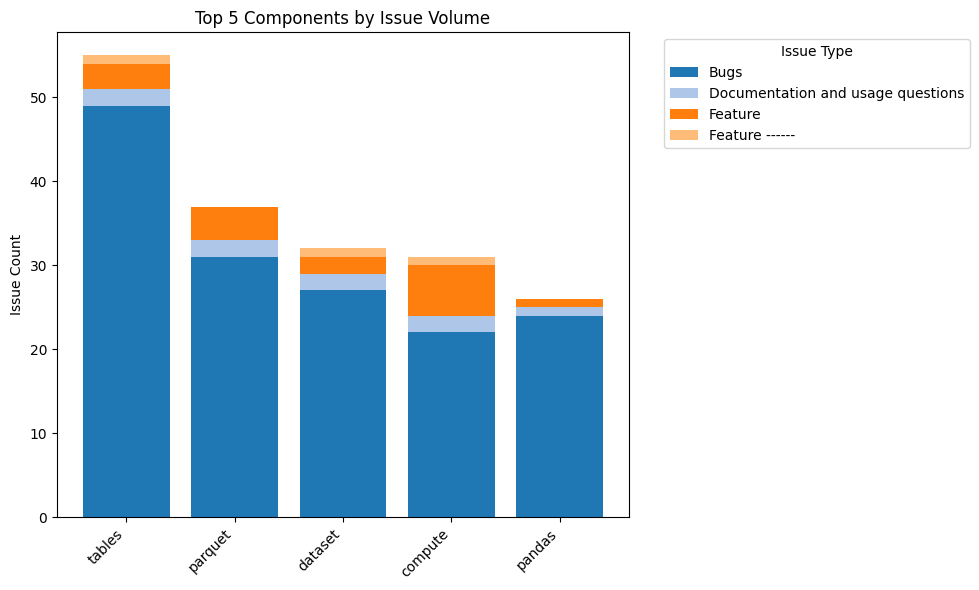

In [14]:
# Step 1: Sort components by total issue count
sorted_components = sorted(pain_point_by_topic.items(), key=lambda x: sum(x[1].values()), reverse=True)
top_5 = sorted_components[:5]

# Step 2: Extract components and reformat data
components = [comp for comp, _ in top_5]
top_data = {comp: pain_point_by_topic[comp] for comp in components}

# Step 3: Extract all issue types (from top 5 only)
all_issue_types = sorted({itype for counts in top_data.values() for itype in counts})
issue_values = {itype: [top_data[comp].get(itype, 0) for comp in components] for itype in all_issue_types}

# Step 4: Plot
plt.figure(figsize=(10, 6))
bottom = [0] * len(components)
colors = plt.cm.tab20.colors

for i, itype in enumerate(all_issue_types):
    plt.bar(components, issue_values[itype], bottom=bottom, label=itype, color=colors[i % len(colors)])
    bottom = [sum(x) for x in zip(bottom, issue_values[itype])]

# Style
plt.xticks(rotation=45, ha='right')
plt.ylabel("Issue Count")
plt.title("Top 5 Components by Issue Volume")
plt.legend(title="Issue Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Specific issues

Get links to the issues inlcuded in the classification

In [15]:
def get_issue_links_by_topic_and_pain_point(issues, component, pain_point):
    """
    Return a list of issue URLs for a specific component and pain point.
    """
    matching_links = []

    # Safety check: ensure the component exists
    if component not in issues:
        return []

    for issue in issues[component]:
        issue_url = issue.get('html_url', '')
        classified_points = issue.get('pain_point', '')

        # Check if the pain_point is one of the classifications
        if any(p.strip() == pain_point for p in classified_points.split(',')):
            matching_links.append(issue_url)

    return matching_links

In [16]:
get_issue_links_by_topic_and_pain_point(classified_issues, component="tables", pain_point="Documentation and usage questions")

['https://github.com/apache/arrow/issues/46781',
 'https://github.com/apache/arrow/issues/46601']

In [17]:
get_issue_links_by_topic_and_pain_point(classified_issues, component="parquet", pain_point="Documentation and usage questions")

['https://github.com/apache/arrow/issues/46781',
 'https://github.com/apache/arrow/issues/46601']